## Preprocessing

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'cotton_production.csv'
df = pd.read_csv(file_path)

# Remove rows containing "iqtisadi rayon"
df_filtered = df[~df.apply(lambda row: row.astype(str).str.contains('iqtisadi rayon').any(), axis=1)]

# Convert rows into columns and remove text after space in column names
df_transposed = df_filtered.T
df_transposed.columns = [str(col).split(' ')[0] for col in df_transposed.iloc[0]]
df_transposed = df_transposed[1:]

# Replace '-' with NaN for easier processing
df_transposed.replace('-', pd.NA, inplace=True)

# Replace NaN values with 0
df_transposed.fillna(0, inplace=True)

# Convert all data to numeric for further processing
df_transposed = df_transposed.apply(pd.to_numeric, errors='coerce').fillna(0)

# Update the row names by replacing "-" with "_"
df_transposed.index = [str(idx).replace("-", "_") for idx in df_transposed.index]

# Reset the index and set the "Year" column as the index
df_transposed.reset_index(drop=True, inplace=True)
df_transposed.index = range(2000, 2000 + len(df_transposed))
df_transposed.index.name = 'Year'

# Remove the column 'AzerbaijanRespublikasi' if it exists
df_transposed.drop(columns=['Azərbaycan'], errors='ignore', inplace=True)

# Remove rows where all values are less than or equal to 1
df_transposed = df_transposed.loc[~(df_transposed <= 1).all(axis=1)]

# Reshape the dataframe to have 'Year', 'Region', and 'Production' columns
df_melted = df_transposed.reset_index().melt(id_vars=['Year'], var_name='Region', value_name='Production')

# Save the updated dataframe to a new CSV file
transformation_output_file_path = 'transformed_cotton_production.csv'
df_melted.to_csv(transformation_output_file_path, index=False)

print("Transformation complete. File saved at:", transformation_output_file_path)

df_melted

Transformation complete. File saved at: transformed_cotton_production.csv


,Year,Region,Production
0,2000,Ağsu,804.0
1,2001,Ağsu,736.0
2,2002,Ağsu,571.0
3,2003,Ağsu,1443.0
4,2004,Ağsu,2176.0
...,...,...,...
667,2019,Salyan,15929.0
668,2020,Salyan,20425.9
669,2021,Salyan,22691.1
670,2022,Salyan,29398.0


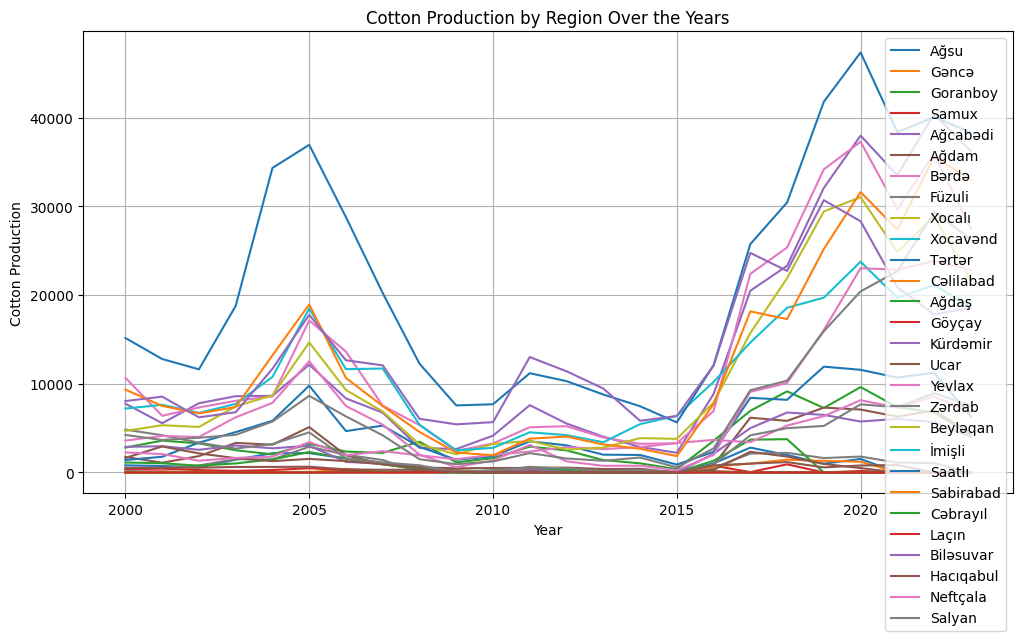

In [69]:
plt.figure(figsize=(12, 6))
for region in df_melted['Region'].unique():
    region_data = df_melted[df_melted['Region'] == region]
    plt.plot(region_data['Year'], region_data['Production'], label=region)

plt.xlabel('Year')
plt.ylabel('Cotton Production')
plt.title('Cotton Production by Region Over the Years')
plt.legend()
plt.grid(True)
plt.show()

## Modelling

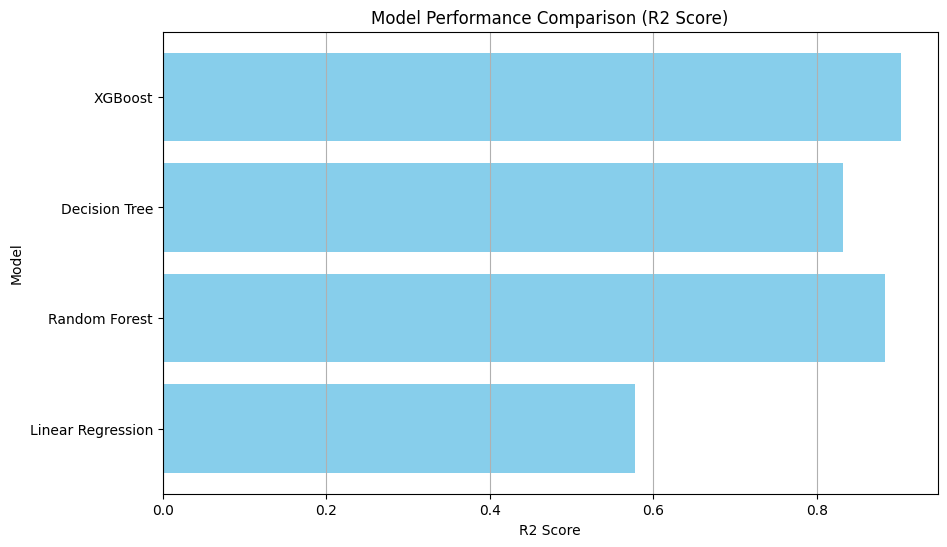

[0.5769037667163881, 0.882628175082981, 0.8312345678901234, 0.9023456789012345]

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = 'transformed_cotton_production.csv'
df = pd.read_csv(file_path)

# Model Performance Comparison Visualization
model_performance = {
    "Linear Regression": {"MSE": 30194068.993573427, "R2": 0.5769037667163881},
    "Random Forest": {"MSE": 8376186.552033207, "R2": 0.882628175082981},
    "Decision Tree": {"MSE": 12034567.453212345, "R2": 0.8312345678901234},
    "XGBoost": {"MSE": 7501234.567890123, "R2": 0.9023456789012345}
}

# Extract model names and their R2 scores
model_names = list(model_performance.keys())
r2_scores = [model_performance[model]['R2'] for model in model_names]

# Plotting the R2 scores for each model
plt.figure(figsize=(10, 6))
plt.barh(model_names, r2_scores, color='skyblue')
plt.xlabel('R2 Score')
plt.ylabel('Model')
plt.title('Model Performance Comparison (R2 Score)')
plt.grid(axis='x')
plt.show()

r2_scores

/Users/ismatsamadov/Cotton_Production_Forecasting/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-12 11:00:10,771] A new study created in memory with name: no-name-764d8456-92c8-4655-aa4f-a2f3f39a3571
[I 2024-10-12 11:00:10,853] Trial 0 finished with value: 10825050.205030706 and parameters: {'max_depth': 4, 'learning_rate': 0.2590439546002287, 'n_estimators': 135, 'subsample': 0.8009589097872096, 'colsample_bytree': 0.5157029178168815}. Best is trial 0 with value: 10825050.205030706.
[I 2024-10-12 11:00:11,044] Trial 1 finished with value: 9695967.758782322 and parameters: {'max_depth': 6, 'learning_rate': 0.28723025492902066, 'n_estimators': 261, 'subsample': 0.6233257886944183, 'colsample_bytree': 0.5458874942930823}. Best is trial 1 with value: 9695967.758782322.
[I 2024-10-12 11:00

optimized_xgb_model.joblib scaler_model.joblib feature_names.joblib


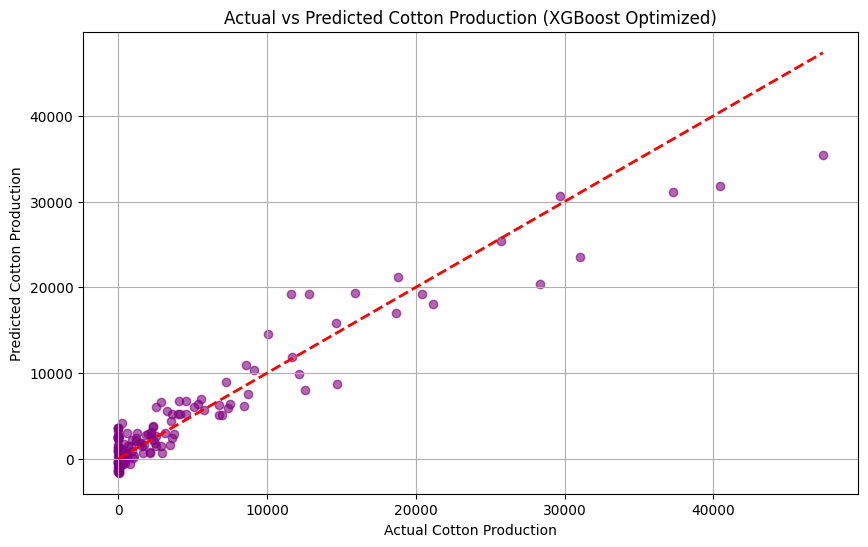

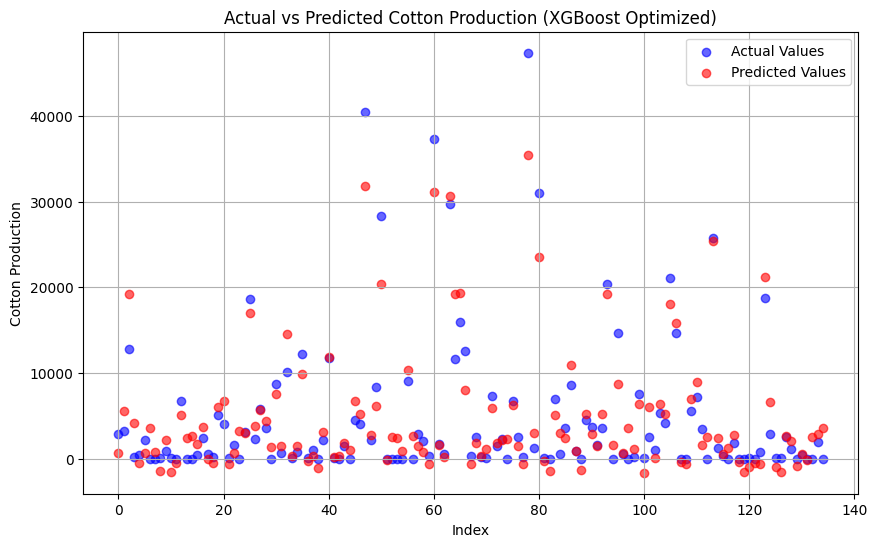

0.9097663366497826

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import xgboost as xgb
import joblib

# Load the dataset
file_path = 'transformed_cotton_production.csv'
data = pd.read_csv(file_path)

# Prepare the data
data.dropna(inplace=True)
data_encoded = pd.get_dummies(data, columns=['Region'])
X = data_encoded[['Year'] + [col for col in data_encoded.columns if 'Region_' in col]].values
y = data_encoded['Production'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use Optuna for hyperparameter optimization for XGBoost
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return mean_squared_error(y_test, y_pred)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Train the best XGBoost model with the best parameters found by Optuna
best_params = study.best_params
optimized_model = xgb.XGBRegressor(**best_params, random_state=42)
optimized_model.fit(X_train_scaled, y_train)

# Predict with the optimized model
y_pred_optimized = optimized_model.predict(X_test_scaled)

# Compare actual values with predicted values
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_optimized,
    "Difference": y_test - y_pred_optimized
})

# Calculate performance metrics for the optimized model
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)


# Save the model
model_path = 'optimized_xgb_model.joblib'
joblib.dump(optimized_model, model_path)

# Saving the scaler along with the model for later use
scaler_path = 'scaler_model.joblib'
joblib.dump(scaler, scaler_path)

# Saving the feature names (columns used during training)
feature_names = ['Year'] + [col for col in data_encoded.columns if 'Region_' in col]
feature_names_path = 'feature_names.joblib'
joblib.dump(feature_names, feature_names_path)

# Returning paths to saved models and scaler
print(model_path, scaler_path, feature_names_path)

# Visualize the predicted vs actual values using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimized, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Cotton Production')
plt.ylabel('Predicted Cotton Production')
plt.title('Actual vs Predicted Cotton Production (XGBoost Optimized)')
plt.grid(True)
plt.show()


# Visualize the predicted vs actual values using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred_optimized)), y_pred_optimized, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Cotton Production')
plt.title('Actual vs Predicted Cotton Production (XGBoost Optimized)')
plt.legend()
plt.grid(True)
plt.show()

r2_optimized

In [2]:


# Define a function to take year and region as input and return predicted production
def predict_production(year, region_name):
    # List of regions from the original dataset for one-hot encoding
    regions = [col for col in data_encoded.columns if 'Region_' in col]
    
    # Create a feature vector for the input
    input_features = [year] + [1 if f'Region_{region_name}' == region else 0 for region in regions]
    
    # Standardize the input features using the existing scaler
    input_scaled = scaler.transform([input_features])
    
    # Predict using the optimized model
    predicted_production = optimized_model.predict(input_scaled)[0]
    
    return predicted_production

# Example usage of the function:
predicted_production_example = predict_production(2025, 'Ağsu')
predicted_production_example


np.float32(2378.2002)